In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import mnist_utils
import semisupervised_vae_lib as ss_vae_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F


# Load data

In [2]:
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=0.001)

In [3]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  6
num_train_unlabled:  54
num_test:  10


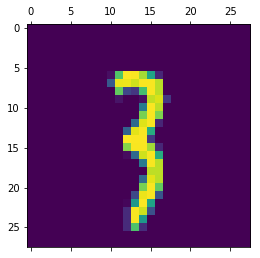

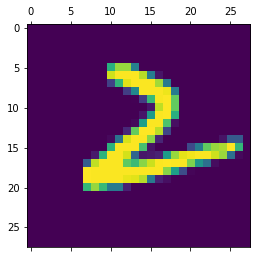

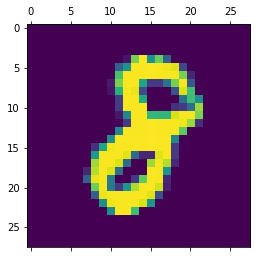

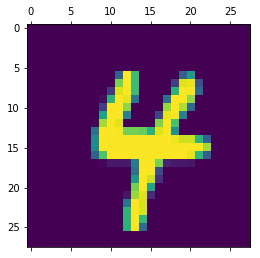

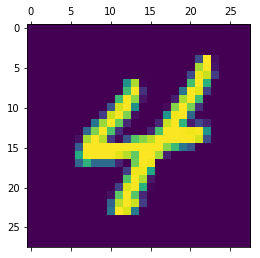

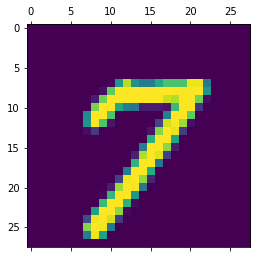

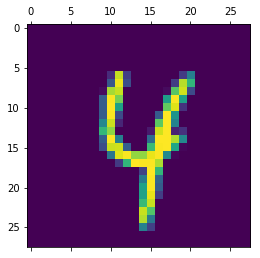

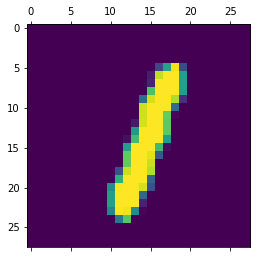

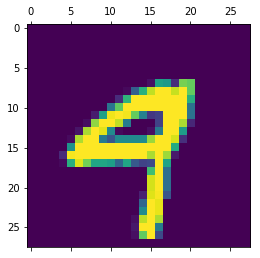

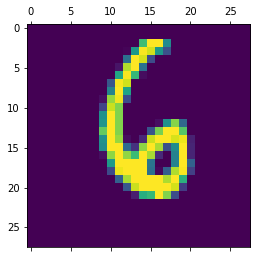

In [4]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() <= 1)
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() >= 0)

In [5]:
slen = train_set_labeled[0]['image'].shape[0]

# Get data loaders

In [6]:
batchsize = 12

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [7]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [8]:
data_unlabeled['image'].shape

torch.Size([12, 28, 28])

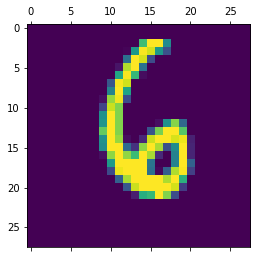

In [9]:
plt.matshow(data_unlabeled['image'][0, :, :])

# Define VAE

In [10]:
latent_dim = 6
n_classes = 10

In [11]:
# vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
#                                     n_classes = n_classes)

vae = mnist_vae_lib.get_mnist_vae(latent_dim = latent_dim, 
                    n_classes = n_classes, 
                   slen = slen)

In [12]:
print(vae.parameters)

<bound method Module.parameters of SemiSupervisedVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=12, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=10, bias=True)
    (log_softmax): LogSoftmax()
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=16, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)>


In [13]:
28 * 28

784

In [14]:
### Check things run

In [15]:
data_unlabeled['image'].shape

torch.Size([12, 28, 28])

In [16]:
# check dimensions of encoder output

log_class_weights = vae.classifier(data_unlabeled['image'])
assert log_class_weights.shape[0] == batchsize
assert log_class_weights.shape[1] == n_classes 

latent_means, latent_std = \
    vae.encoder(data_unlabeled['image'], log_class_weights)
    
assert latent_means.shape[0] == batchsize
assert latent_means.shape[1] == latent_dim

assert latent_std.shape[0] == batchsize
assert latent_std.shape[1] == latent_dim


In [17]:
cat_rv = torch.distributions.Categorical(probs = torch.exp(log_class_weights))
z_ind = cat_rv.sample()

In [18]:
z_ind

tensor([ 2,  4,  5,  8,  6,  0,  1,  6,  4,  2,  1,  5])

In [19]:
# check one hot encoding 

one_hot_z = mnist_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

for n in range(batchsize): 
    foo = one_hot_z[n, :]
    
    assert foo[z_ind[n]] == 1.
    assert sum(foo) == 1.

In [20]:
# check decoder output size 
image_mean = vae.decoder(latent_means, one_hot_z)
assert image_mean.shape[0] == batchsize
assert image_mean.shape[1] == slen
assert image_mean.shape[1] == slen

In [21]:
# check loss goes through

In [22]:
vae.get_conditional_loss(data_labeled['image'], data_labeled['label'])

tensor([ 544.0783,  544.1681,  543.3316,  544.3527,  544.8186,  543.8315])

In [23]:
vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 1000,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)

(tensor(1.00000e+05 *
        5.4480), tensor(6523.9214))

# Check gradient works 

In [24]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [25]:
vae_params0 = get_vae_params(vae)

In [26]:
assert np.any(np.isnan(vae_params0)) == False

In [27]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [28]:
loss, map_loss1 = vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100, 
                            use_baseline = True,
                            alpha = 1.0, topk = 0)
print(map_loss1)

tensor(6527.7715)


In [29]:
loss.backward()
optimizer.step()

In [30]:
vae_params1 = get_vae_params(vae)

In [31]:
assert np.any(np.isnan(vae_params1)) == False

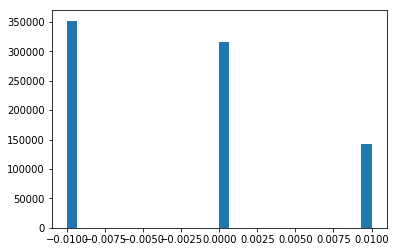

In [32]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [33]:
loss, map_loss2 = vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)


In [34]:
map_loss2

tensor(5723.9644)

In [35]:
assert np.isfinite(loss.detach().numpy())

# Test training

In [36]:
from torch.utils.data.sampler import Sampler

In [37]:
ss_vae_lib.train_semisupervised_model(vae, train_loader_unlabeled, 
                                        data_labeled['image'], 
                                        data_labeled['label'], 
                                        test_loader, 
                                        n_epoch = 5, print_every = 2, outfile = './test', 
                                        use_true_labels = False)

  * init train recon loss: 475.8141479;
  * init test recon loss: 482.923584;
  * init train class accuracy: 0.1667;
  * init test class accuracy:  0.1;
[1] unlabeled_loss: 466.1678467  	[0.1 seconds]
[2] unlabeled_loss: 457.885376  	[0.1 seconds]
  * train recon loss: 451.5549622;
  * test recon loss: 449.095459;
  * labeled class accuracy:    1;
  * train class accuracy: 0.09259;
  * test class accuracy:    0;
[3] unlabeled_loss: 447.4191895  	[0.1 seconds]
[4] unlabeled_loss: 436.7545166  	[0.1 seconds]
  * train recon loss: 433.5417786;
  * test recon loss: 438.9585876;
  * labeled class accuracy:    1;
  * train class accuracy: 0.09259;
  * test class accuracy:    0;
[5] unlabeled_loss: 427.1835938  	[0.1 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final

writing the classifier parameters to ./test_classifier_final



In [38]:
torch.exp(vae.classifier(data_unlabeled['image']).detach())

tensor([[ 0.1099,  0.0681,  0.1200,  0.0951,  0.1012,  0.0927,  0.0826,
          0.1464,  0.0980,  0.0861],
        [ 0.1132,  0.0704,  0.1143,  0.0953,  0.1009,  0.0858,  0.0869,
          0.1486,  0.0990,  0.0856],
        [ 0.1114,  0.0691,  0.1144,  0.0969,  0.0994,  0.0859,  0.0913,
          0.1473,  0.0998,  0.0846],
        [ 0.1110,  0.0690,  0.1163,  0.0962,  0.1005,  0.0882,  0.0877,
          0.1472,  0.0983,  0.0855],
        [ 0.1114,  0.0687,  0.1159,  0.0962,  0.1003,  0.0887,  0.0871,
          0.1480,  0.0985,  0.0853],
        [ 0.1150,  0.0663,  0.1162,  0.0951,  0.0995,  0.0845,  0.0850,
          0.1570,  0.0992,  0.0822],
        [ 0.1130,  0.0678,  0.1163,  0.0945,  0.0992,  0.0859,  0.0875,
          0.1519,  0.0987,  0.0850],
        [ 0.1117,  0.0691,  0.1136,  0.0955,  0.0982,  0.0872,  0.0929,
          0.1478,  0.1010,  0.0831],
        [ 0.1142,  0.0674,  0.1186,  0.0939,  0.1013,  0.0850,  0.0844,
          0.1548,  0.0967,  0.0838],
        [ 0.1139,  

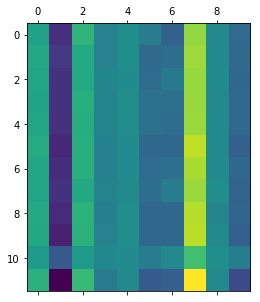

In [39]:
plt.matshow(vae.classifier(data_unlabeled['image']).detach())

In [40]:
# check reloading

In [43]:
reload_vae = mnist_vae_lib.get_mnist_vae(latent_dim = latent_dim, 
                    n_classes = n_classes, 
                   slen = slen)


# mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
#                                     n_classes = n_classes)

In [44]:
enc_file = "./test_enc_final"
dec_file = './test_dec_final'

reload_vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

reload_vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))


In [45]:
reload_vae.eval_vae(train_loader_unlabeled, data_labeled['image'], 
                                        data_labeled['label'])

tensor(433.1495)

In [48]:
recon_mean, _ =  ss_vae_lib.get_reconstructions(vae, data_unlabeled['image'])

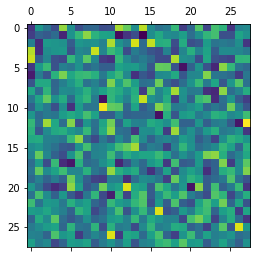

In [49]:
plt.matshow(recon_mean[3, :, :].detach())